# Segmenting remote sensing imagery with text/input prompts and the Segment Anything Model (SAM)

The first part of this notebook shows how to generate object masks from text prompts with the Segment Anything Model (SAM), in the second one we the generate masks from input prompts. We use Sentinel Hub Process API to download satellite imagery.

*Note:* this notebook combines two notebooks and has been modified from the original, located [here](https://samgeo.gishub.org/examples/text_prompts/) and [here](https://samgeo.gishub.org/examples/input_prompts/). 

## Install dependencies

In [1]:
from sentinelhub import SHConfig

config = SHConfig("sentinel-hub-dida-testing")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
import leafmap
from samgeo import SamGeo
from samgeo.text_sam import LangSAM
from ipyleaflet.leaflet import DrawControl
import rasterio

import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    bbox_to_dimensions,
)

from amoki.config import DATA_DIR

## Create an interactive map

In [3]:
m = leafmap.Map(center=[50.895, 6.45], zoom=12, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[50.895, 6.45], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

## Download a sample image

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map.  
If nothing is selected, the coordinates for the Hambach Surface Mine will be used.

In [4]:
coords = m.user_roi_bounds()
if coords is None:
    coords = [6.399536,50.838034,6.645355,50.962319]

coords

[6.4198, 50.8623, 6.6251, 50.9517]

You can also use your own image. Uncomment and run the following cell to use your own image.

In [5]:
# img_path = '/path/to/your/own/image.tif'

### Download image from Sentinel Hub

We download imagery of the Hambach surface mine with the least cloud coverage.

In [6]:
resolution = 10
bbox = BBox(bbox=coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (1477, 945) pixels


In [7]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    data_folder=DATA_DIR / 'samgeo',
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2019-01-01", "2019-12-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

In [8]:
img = request_true_color.get_data(save_data=True)

In [9]:
# Get the last added image
for folder, _, filenames in os.walk(request_true_color.data_folder):
    for filename in filenames:
        if filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img_folder = folder
            print(os.path.join(folder, filename))

~project/data/samgeo/48ed30dd6ed1a33290afe08594a0533f/response.tiff
~project/data/samgeo/3c0f23d0c2ace87c4340237074a897cf/response.tiff
~project/data/samgeo/21c30b034d83c5cb4f395b7a7d3d2aba/response.tiff


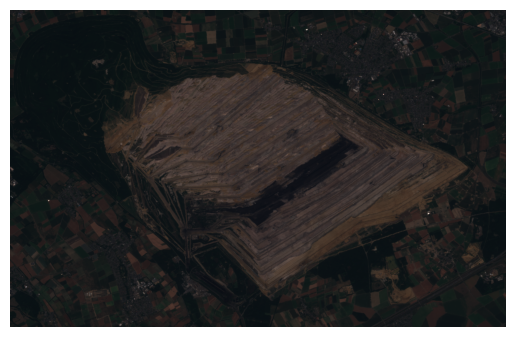

In [10]:
with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3])
    img = img.transpose((1, 2, 0))


plt.imshow(img)
plt.axis('off')
plt.show()

## Generating object masks with text prompts

### Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [11]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


### Specify text prompts

In [12]:
text_prompt = "pit"

### Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [13]:
sam.predict(img_path, text_prompt, box_threshold=0.35, text_threshold=0.24)

### Visualize the results

Show the result with bounding boxes on the map.

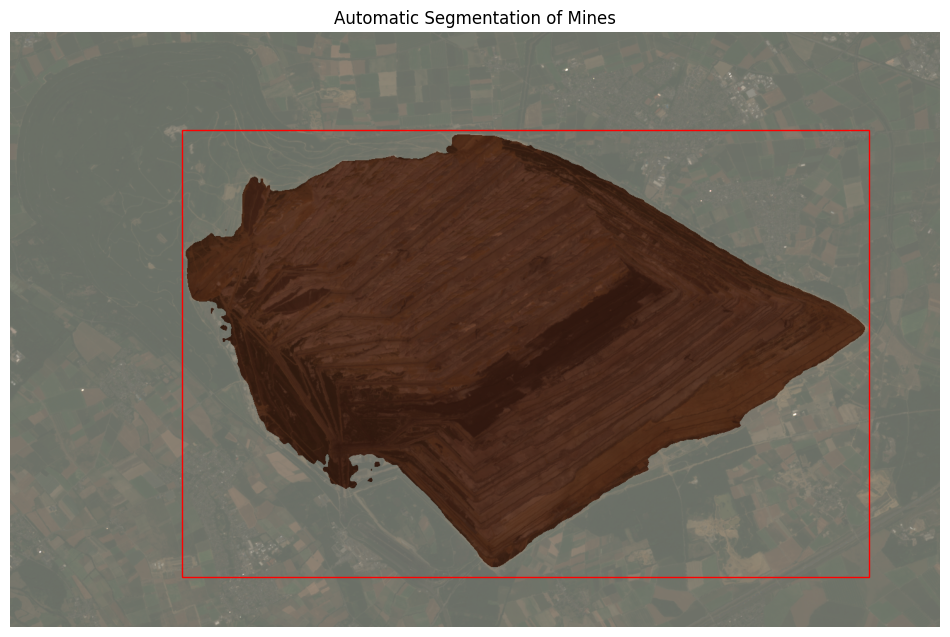

In [14]:
sam.show_anns(
    cmap="YlOrBr",
    box_color="red",
    title="Automatic Segmentation of Mines",
    blend=True,
)

Show the result as a grayscale image.

In [15]:
img_folder

'~project/data/samgeo/21c30b034d83c5cb4f395b7a7d3d2aba'

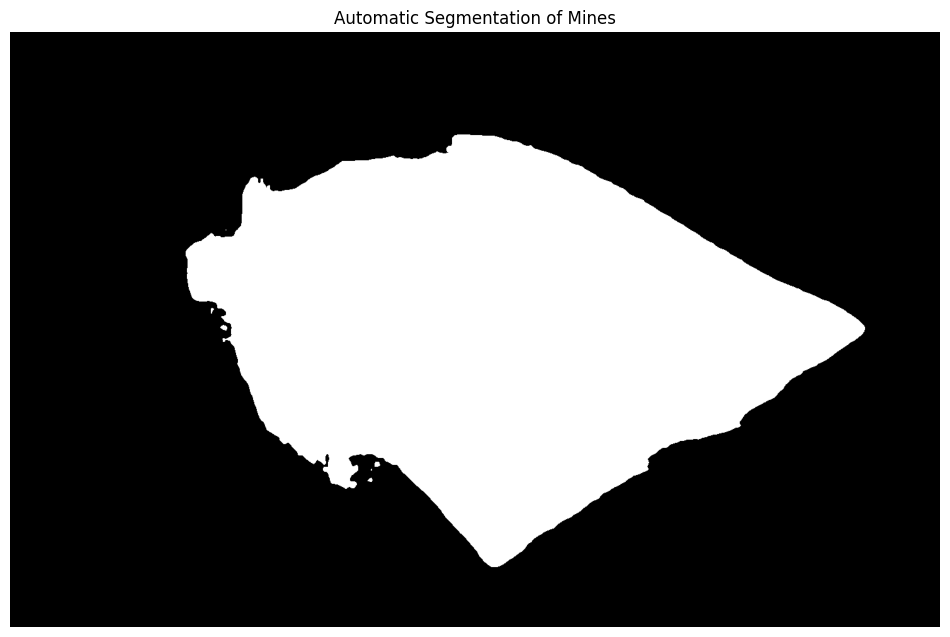

In [16]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Mines",
    blend=False,
    output= os.path.join(img_folder,"mines_grayscale.tif"),
)

Convert the result to a vector format.  

In [17]:
sam.raster_to_vector(os.path.join(img_folder,"mines_grayscale.tif"), os.path.join(img_folder,"mines_grayscale.shp"))

Show the results on the interactive map.

In [18]:
m.add_raster(os.path.join(img_folder,"mines_grayscale.tif"), layer_name="Mines", palette="YlOrBr", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(os.path.join(img_folder,"mines_grayscale.shp"), layer_name="Vector", style=style)
m

Map(bottom=351925.0, center=[50.907, 6.52245], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

## Generating object masks from input prompts

### Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

Set `automatic=False` to disable the `SamAutomaticMaskGenerator` and enable the `SamPredictor`.

In [19]:
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

Specify the image to segment. 

In [20]:
sam.set_image(img_path)

### Image segmentation with input points

A single point can be used to segment an object. The point can be specified as a tuple of (x, y), such as (col, row) or (lon, lat). The points can also be specified as a file path to a vector dataset. For non (col, row) input points, specify the `point_crs` parameter, which will automatically transform the points to the image column and row coordinates.

In [21]:
with rasterio.open(img_path) as dataset:
    bounds = dataset.bounds
    center_x = (bounds.left + bounds.right) / 2
    center_y = (bounds.top + bounds.bottom) / 2

    print(f"Center coordinates of the saved satellite image: ({center_x}, {center_y})")


Center coordinates of the saved satellite image: (6.52245, 50.907)


In [22]:
m = leafmap.Map(center=[center_y, center_x], zoom=12, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[50.907, 6.52245], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Use the draw tools to put a marker on the map above.  
If nothing is selected, the coordinates for the Hambach Surface Mine will be used.

In [26]:
markers = [control.data for control in m.controls if type(control)==DrawControl]
markers_coords = [marker['geometry']['coordinates'] for marker in markers[0]]

markers_coords

[]

In [27]:
if len(markers_coords) == 0:
    point_coords = [(6.52, 50.91)]
else:
    point_coords = markers_coords

You can try a single or multiple points input.

In [28]:
sam.predict(point_coords, point_labels=1, point_crs="EPSG:4326",  output=os.path.join(img_folder,"mask.tif"), multimask_output=False)

Convert the result to a vector format.  

In [29]:
sam.raster_to_vector(os.path.join(img_folder,"mask.tif"), os.path.join(img_folder,"mask.shp"))

Show the results on the interactive map.

In [30]:
m.add_raster(os.path.join(img_folder,"mask.tif"), layer_name="Mask1", palette="YlOrBr", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(os.path.join(img_folder,"mask.shp"), layer_name="Vector1", style=style)
m

Map(bottom=351870.0, center=[50.907, 6.52245], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…